# Tutorial 5: Synaptic Plasticity Modeling - Foundation of Learning and Memory

Synaptic plasticity is the biological foundation of learning and memory in neural systems. The strength (weight) of synapses dynamically changes according to neural activity patterns, following specific learning rules.

BrainEvent provides efficient implementations of synaptic plasticity, supporting various learning rules and data structures.

## Contents
1. Biological Background of Synaptic Plasticity
2. STDP - Spike-Timing-Dependent Plasticity
3. Implementing STDP on CSR Format
4. Implementing STDP on COO Format
5. Implementing STDP on Dense Matrices
6. Practice: Building an Adaptive Network
7. Advanced: Multiple Synaptic Plasticity Rules

## 1. Biological Background of Synaptic Plasticity

### Hebb's Rule
> "Neurons that fire together, wire together" (Neurons that fire together, wire together)

This is a learning principle proposed by Donald Hebb in 1949, and modern neuroscience has confirmed that synaptic plasticity indeed exists.

### STDP (Spike-Timing-Dependent Plasticity)

**Spike-Timing-Dependent Plasticity**is the most important synaptic plasticity mechanism:

- 🧠 **LTP (Long-Term Potentiation)**: If the presynaptic neuron spike occurs **before** the postsynaptic neuron, the synapse is strengthened
- 🧠 **LTD (Long-Term Depression)**: If the presynaptic neuron spike occurs **after** the postsynaptic neuron, the synapse is weakened

### Mathematical Expression

STDP weight update rule:

$$\Delta w = \begin{cases}
A_{+} \cdot \text{trace}_{post} & \text{if pre-spike} \\
A_{-} \cdot \text{trace}_{pre} & \text{if post-spike}
\end{cases}$$

where trace is the exponentially decaying spike trace:
$$\text{trace}(t) = \text{trace}(t-dt) \cdot e^{-dt/\tau} + \text{spike}(t)$$

### Implementation in BrainEvent

BrainEvent provides several core functions:
- **`csr_on_pre`**: Presynaptic spike-triggered weight update (CSR format)
- **`coo_on_pre`**: Presynaptic spike-triggered weight update (COO format)
- **`dense_on_pre`**: Presynaptic spike-triggered weight update (dense format)
- as well as corresponding `_on_post` versions

In [1]:
import brainevent
import brainstate
import braintools
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt

print(f"BrainEvent version: {brainevent.__version__}")


BrainEvent version: 0.0.4


## 2. Basic STDP Implementation

Let's first implement a simple STDP learning system.

In [2]:
class STDPSystem:
    """System implementing STDP learning rules"""
    
    def __init__(self, 
                 tau_pre=20.0,    # Presynaptic trace time constant (ms)
                 tau_post=20.0,   # Postsynaptic trace time constant (ms)
                 A_plus=0.01,     # LTP learning rate
                 A_minus=0.01,    # LTD learning rate
                 dt=1.0):         # Time step (ms)
        self.tau_pre = tau_pre
        self.tau_post = tau_post
        self.A_plus = A_plus
        self.A_minus = A_minus
        self.dt = dt
        
        # trace decay factor
        self.decay_pre = np.exp(-dt / tau_pre)
        self.decay_post = np.exp(-dt / tau_post)
        
        print(f"STDP system configuration:")
        print(f"  τ_pre:  {tau_pre} ms")
        print(f"  τ_post: {tau_post} ms")
        print(f"  A+:     {A_plus}")
        print(f"  A-:     {A_minus}")
        print(f"  dt:     {dt} ms")
    
    def update_traces(self, pre_trace, post_trace, pre_spike, post_spike):
        """Update presynaptic and postsynaptic traces"""
        # Exponential decay + spike increment
        pre_trace = pre_trace * self.decay_pre + pre_spike.astype(jnp.float32)
        post_trace = post_trace * self.decay_post + post_spike.astype(jnp.float32)
        return pre_trace, post_trace
    
    def stdp_window(self, delta_t_range=(-50, 50)):
        """Calculate STDP window function"""
        delta_t = np.linspace(delta_t_range[0], delta_t_range[1], 1000)
        dw = np.where(
            delta_t > 0,
            self.A_plus * np.exp(-delta_t / self.tau_post),
            -self.A_minus * np.exp(delta_t / self.tau_pre)
        )
        return delta_t, dw

# Create STDP system
stdp = STDPSystem(tau_pre=20.0, tau_post=20.0, A_plus=0.01, A_minus=0.01, dt=1.0)

STDP system configuration:
  τ_pre:  20.0 ms
  τ_post: 20.0 ms
  A+:     0.01
  A-:     0.01
  dt:     1.0 ms


### Visualize STDP Window

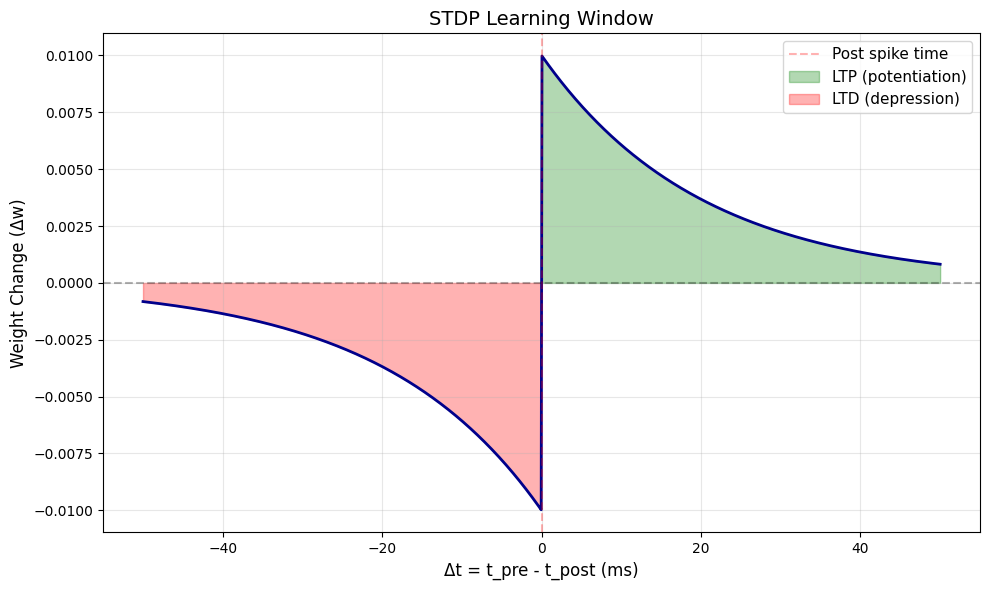

Explanation:
  Δt > 0: Pre before post → strengthen synapse (LTP)
  Δt < 0: Pre after post → weaken synapse (LTD)


In [3]:
# Plot STDP learning window
delta_t, dw = stdp.stdp_window()

plt.figure(figsize=(10, 6))
plt.plot(delta_t, dw, linewidth=2, color='darkblue')
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.axvline(0, color='red', linestyle='--', alpha=0.3, label='Post spike time')
plt.fill_between(delta_t[delta_t > 0], 0, dw[delta_t > 0], alpha=0.3, color='green', label='LTP (potentiation)')
plt.fill_between(delta_t[delta_t < 0], 0, dw[delta_t < 0], alpha=0.3, color='red', label='LTD (depression)')
plt.xlabel('Δt = t_pre - t_post (ms)', fontsize=12)
plt.ylabel('Weight Change (Δw)', fontsize=12)
plt.title('STDP Learning Window', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Explanation:")
print("  Δt > 0: Pre before post → strengthen synapse (LTP)")
print("  Δt < 0: Pre after post → weaken synapse (LTD)")

## 3. Implementing STDP on CSR Format

The `csr_on_pre` function of BrainEvent can efficiently implement STDP on CSR sparse matrices.

In [4]:
# Create a simple neural network
n_pre = 100
n_post = 50
conn_prob = 0.1

# Generate sparse connections
brainstate.random.seed(42)

mask = brainstate.random.bernoulli(conn_prob, size=(n_pre, n_post))
weights_dense = brainstate.random.uniform(0.0, 0.5, size=(n_pre, n_post)) * mask

# Convert to CSR format (manual construction, since COO.to_csr() is not available)
row_idx, col_idx = jnp.where(weights_dense != 0)
data = weights_dense[row_idx, col_idx]

# Manually build CSR format
csr_data = []
csr_indices = []
csr_indptr = [0]

for i in range(n_pre):
    row = weights_dense[i]
    nz_indices = jnp.where(row != 0)[0]
    csr_indices.extend(nz_indices.tolist())
    csr_data.extend(row[nz_indices].tolist())
    csr_indptr.append(len(csr_indices))

csr_weights = brainevent.CSR(
    (jnp.array(csr_data), jnp.array(csr_indices), jnp.array(csr_indptr)),
    shape=(n_pre, n_post)
)

print(f"Network configuration:")
print(f"  Presynaptic neurons: {n_pre}")
print(f"  Postsynaptic neurons: {n_post}")
print(f"  Number of connections: {csr_weights.nse}")
print(f"  Initial weight range: [{csr_weights.data.min():.3f}, {csr_weights.data.max():.3f}]")


Network configuration:
  Presynaptic neurons: 100
  Postsynaptic neurons: 50
  Number of connections: 542
  Initial weight range: [0.002, 0.500]


In [5]:
# Simulate network running and apply STDP
n_steps = 500
dt = 1.0  # ms

# Initialize trace
pre_trace = jnp.zeros(n_pre)
post_trace = jnp.zeros(n_post)

# Record weight changes
weight_history = [csr_weights.data.mean()]
weight_std_history = [csr_weights.data.std()]

# STDP parameters
tau_pre = 20.0
tau_post = 20.0
A_plus = 0.005
A_minus = 0.005

decay_pre = np.exp(-dt / tau_pre)
decay_post = np.exp(-dt / tau_post)

print("Starting STDP learning...\n")

brainstate.random.seed(100)

for step in range(n_steps):
    # Generate random spikes
    pre_spike = brainstate.random.bernoulli(0.05, size=(n_pre,))
    post_spike = brainstate.random.bernoulli(0.05, size=(n_post,))

    # Update trace (decay + spike)
    pre_trace = pre_trace * decay_pre + pre_spike.astype(jnp.float32)
    post_trace = post_trace * decay_post + post_spike.astype(jnp.float32)

    # STDP rule 1: Presynaptic spike trigger (LTP)
    # If presynaptic fires, strengthen weights based on postsynaptic trace
    new_weights = brainevent.binary_csr_plast(
        weight=csr_weights.data,
        indices=csr_weights.indices,
        indptr=csr_weights.indptr,
        pre_spike=pre_spike,
        post_trace=post_trace * A_plus,
        w_min=0.0,
        w_max=1.0,
        shape=csr_weights.shape
    )

    # Update weights
    csr_weights = brainevent.CSR((new_weights, csr_weights.indices, csr_weights.indptr), shape=csr_weights.shape)

    # Record statistics
    if step % 10 == 0:
        weight_history.append(csr_weights.data.mean())
        weight_std_history.append(csr_weights.data.std())

print(f"STDP learning completed!")
print(f"  Final weight range: [{csr_weights.data.min():.3f}, {csr_weights.data.max():.3f}]")
print(f"  Mean Weight: {csr_weights.data.mean():.3f}")
print(f"  Weight change: {(csr_weights.data.mean() - weight_history[0]):.3f}")


Starting STDP learning...

STDP learning completed!
  Final weight range: [0.040, 0.697]
  Mean Weight: 0.382
  Weight change: 0.124


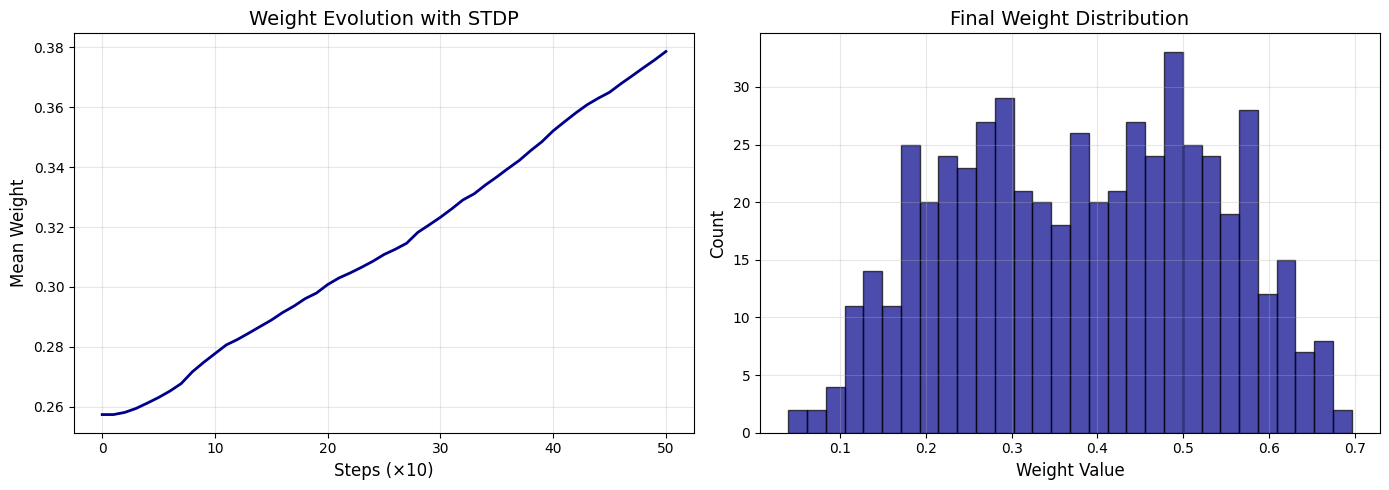

In [6]:
# Visualize Weight Evolution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean Weight
axes[0].plot(weight_history, linewidth=2, color='darkblue')
axes[0].set_xlabel('Steps (×10)', fontsize=12)
axes[0].set_ylabel('Mean Weight', fontsize=12)
axes[0].set_title('Weight Evolution with STDP', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Weight distribution
axes[1].hist(csr_weights.data, bins=30, alpha=0.7, color='darkblue', edgecolor='black')
axes[1].set_xlabel('Weight Value', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Final Weight Distribution', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Implementing STDP on COO Format

For scenarios requiring frequent modification of connection structure, COO format is more flexible.

In [7]:
# Using COO format
n_pre = 80
n_post = 40

# Create COO matrix
brainstate.random.seed(123)

n_synapses = 400
pre_ids = brainstate.random.randint(0, n_pre, size=(n_synapses,))
post_ids = brainstate.random.randint(0, n_post, size=(n_synapses,))
weights = brainstate.random.uniform(0.1, 0.5, size=(n_synapses,))

coo_weights = brainevent.COO((weights, pre_ids, post_ids), shape=(n_pre, n_post))

print(f"COO network:")
print(f"  Shape: {coo_weights.shape}")
print(f"  Number of synapses: {n_synapses}")
print(f"  Initial weights: {coo_weights.data.mean():.3f} ± {coo_weights.data.std():.3f}")


COO network:
  Shape: (80, 40)
  Number of synapses: 400
  Initial weights: 0.307 ± 0.118


In [8]:
# Implementing STDP using coo_on_pre
n_steps = 300
pre_trace = jnp.zeros(n_pre)
post_trace = jnp.zeros(n_post)

weight_mean_history = [coo_weights.data.mean()]

brainstate.random.seed(999)

for step in range(n_steps):
    # Generate spikes
    pre_spike = brainstate.random.bernoulli(0.08, size=(n_pre,))
    post_spike = brainstate.random.bernoulli(0.08, size=(n_post,))

    # Update trace
    pre_trace = pre_trace * decay_pre + pre_spike.astype(jnp.float32)
    post_trace = post_trace * decay_post + post_spike.astype(jnp.float32)

    # 使用coo_on_preUpdate weights
    new_weights = brainevent.coo_on_pre(
        weight=coo_weights.data,
        pre_ids=coo_weights.row,
        post_ids=coo_weights.col,
        pre_spike=pre_spike,
        post_trace=post_trace * A_plus,
        w_min=0.0,
        w_max=1.0
    )

    # Update COO matrix
    coo_weights = brainevent.COO((new_weights, coo_weights.row, coo_weights.col), shape=coo_weights.shape)

    if step % 10 == 0:
        weight_mean_history.append(coo_weights.data.mean())

print(f"\nCOO-STDP learning completed:")
print(f"  Final weights: {coo_weights.data.mean():.3f} ± {coo_weights.data.std():.3f}")
print(f"  Weight change: {(coo_weights.data.mean() - weight_mean_history[0]):.3f}")



COO-STDP learning completed:
  Final weights: 0.493 ± 0.127
  Weight change: 0.186


## 5. Practice: Building a Self-Learning Neural Network

Let's build a complete spiking neural network with STDP learning capability.

In [12]:
class AdaptiveSpikingNetwork:
    """Spiking neural network with STDP learning capability"""

    def __init__(self, n_input, n_hidden, n_output, conn_prob=0.15, seed=0):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output

        brainstate.random.seed(seed)

        # Create sparse connections (CSR format)
        # First layer
        mask1 = brainstate.random.bernoulli(conn_prob, size=(n_input, n_hidden))
        w1 = brainstate.random.uniform(0.0, 0.3, size=(n_input, n_hidden)) * mask1

        # Manually build CSR format
        csr_data1 = []
        csr_indices1 = []
        csr_indptr1 = [0]
        for i in range(n_input):
            row = w1[i]
            nz = jnp.where(row != 0)[0]
            csr_indices1.extend(nz.tolist())
            csr_data1.extend(row[nz].tolist())
            csr_indptr1.append(len(csr_indices1))
        self.w1 = brainevent.CSR(
            (jnp.array(csr_data1), jnp.array(csr_indices1), jnp.array(csr_indptr1)),
            shape=(n_input, n_hidden)
        )

        # Second layer
        mask2 = brainstate.random.bernoulli(conn_prob, size=(n_hidden, n_output))
        w2 = brainstate.random.uniform(0.0, 0.3, size=(n_hidden, n_output)) * mask2

        csr_data2 = []
        csr_indices2 = []
        csr_indptr2 = [0]
        for i in range(n_hidden):
            row = w2[i]
            nz = jnp.where(row != 0)[0]
            csr_indices2.extend(nz.tolist())
            csr_data2.extend(row[nz].tolist())
            csr_indptr2.append(len(csr_indices2))
        self.w2 = brainevent.CSR(
            (jnp.array(csr_data2), jnp.array(csr_indices2), jnp.array(csr_indptr2)),
            shape=(n_hidden, n_output)
        )

        # Initialize trace
        self.input_trace = jnp.zeros(n_input)
        self.hidden_trace = jnp.zeros(n_hidden)
        self.output_trace = jnp.zeros(n_output)

        # STDP parameters
        self.tau = 20.0
        self.A_plus = 0.008
        self.decay = np.exp(-1.0 / self.tau)

        print(f"Adaptive network: {n_input} -> {n_hidden} -> {n_output}")
        print(f"  First layer connection: {self.w1.nse}")
        print(f"  Second layer connection: {self.w2.nse}")

    def forward(self, input_spikes, learning=True):
        """Forward propagation, optional learning"""
        # First layer
        hidden_input = input_spikes @ self.w1
        hidden_spikes = brainevent.EventArray(hidden_input > 0.5)

        # Second layer
        output_input = hidden_spikes @ self.w2
        output_spikes = brainevent.EventArray(output_input > 0.8)

        # Update trace
        input_arr = input_spikes.value if isinstance(input_spikes, brainevent.EventArray) else input_spikes
        self.input_trace = self.input_trace * self.decay + input_arr.astype(jnp.float32)
        self.hidden_trace = self.hidden_trace * self.decay + hidden_spikes.astype(jnp.float32)
        self.output_trace = self.output_trace * self.decay + output_spikes.astype(jnp.float32)

        # STDP learning
        if learning:
            # update First layer weight
            new_w1 = brainevent.binary_csr_plast(
                weight=self.w1.data,
                indices=self.w1.indices,
                indptr=self.w1.indptr,
                pre_spike=input_spikes.value if isinstance(input_spikes, brainevent.EventArray) else input_spikes,
                post_trace=self.hidden_trace * self.A_plus,
                w_min=0.0,
                w_max=1.0,
                shape=self.w1.shape
            )
            self.w1 = brainevent.CSR((new_w1, self.w1.indices, self.w1.indptr), shape=self.w1.shape)

            # update Second layer weight
            new_w2 = brainevent.binary_csr_plast(
                weight=self.w2.data,
                indices=self.w2.indices,
                indptr=self.w2.indptr,
                pre_spike=hidden_spikes.value if isinstance(hidden_spikes, brainevent.EventArray) else hidden_spikes,
                post_trace=self.output_trace * self.A_plus,
                w_min=0.0,
                w_max=1.0,
                shape=self.w2.shape
            )
            self.w2 = brainevent.CSR((new_w2, self.w2.indices, self.w2.indptr), shape=self.w2.shape)

        return output_input, hidden_spikes, output_spikes

# Create adaptive network
adaptive_net = AdaptiveSpikingNetwork(
    n_input=200,
    n_hidden=100,
    n_output=10,
    conn_prob=0.12,
    seed=2024
)



Adaptive network: 200 -> 100 -> 10
  First layer connection: 2433
  Second layer connection: 123


In [13]:
# Train Network
n_epochs = 50
n_samples_per_epoch = 20

w1_history = []
w2_history = []
output_activity_history = []

# Record spike activity for visualization
hidden_spike_matrix = []
output_spike_matrix = []

brainstate.random.seed(0)

print("Starting training...\n")

for epoch in range(n_epochs):
    epoch_output_count = 0

    for sample in range(n_samples_per_epoch):
        # Generate random input pattern
        input_pattern = brainstate.random.bernoulli(0.1, size=(200,))
        input_spikes = brainevent.EventArray(input_pattern)

        # Forward propagation + learning
        output, hidden_spk, output_spk = adaptive_net.forward(input_spikes, learning=True)
        epoch_output_count += int(output_spk.sum())

        # Record spike activity in last epoch (first 50 neurons)
        if epoch == n_epochs - 1:
            hidden_spike_matrix.append(np.array(hidden_spk.value[:50], dtype=int))
            output_spike_matrix.append(np.array(output_spk.value, dtype=int))

    # Record statistics
    w1_history.append(adaptive_net.w1.data.mean())
    w2_history.append(adaptive_net.w2.data.mean())
    output_activity_history.append(epoch_output_count / n_samples_per_epoch)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: W1={w1_history[-1]:.4f}, W2={w2_history[-1]:.4f}, Output={output_activity_history[-1]:.2f}")

# Convert to arrays for visualization
hidden_spike_matrix = np.array(hidden_spike_matrix)  # (20, 50)
output_spike_matrix = np.array(output_spike_matrix)  # (20, 10)

print(f"\nTraining completed!")
print(f"  First layerWeight change: {w1_history[0]:.4f} -> {w1_history[-1]:.4f}")
print(f"  Second layerWeight change: {w2_history[0]:.4f} -> {w2_history[-1]:.4f}")
print(f"  Total hidden layer spikes: {hidden_spike_matrix.sum()}")
print(f"  Total output layer spikes: {output_spike_matrix.sum()}")


Starting training...

Epoch 0: W1=0.1965, W2=0.3578, Output=4.35
Epoch 10: W1=0.9997, W2=1.0000, Output=10.00
Epoch 20: W1=1.0000, W2=1.0000, Output=10.00
Epoch 30: W1=1.0000, W2=1.0000, Output=10.00
Epoch 40: W1=1.0000, W2=1.0000, Output=10.00

Training completed!
  First layerWeight change: 0.1965 -> 1.0000
  Second layerWeight change: 0.3578 -> 1.0000
  Total hidden layer spikes: 921
  Total output layer spikes: 200


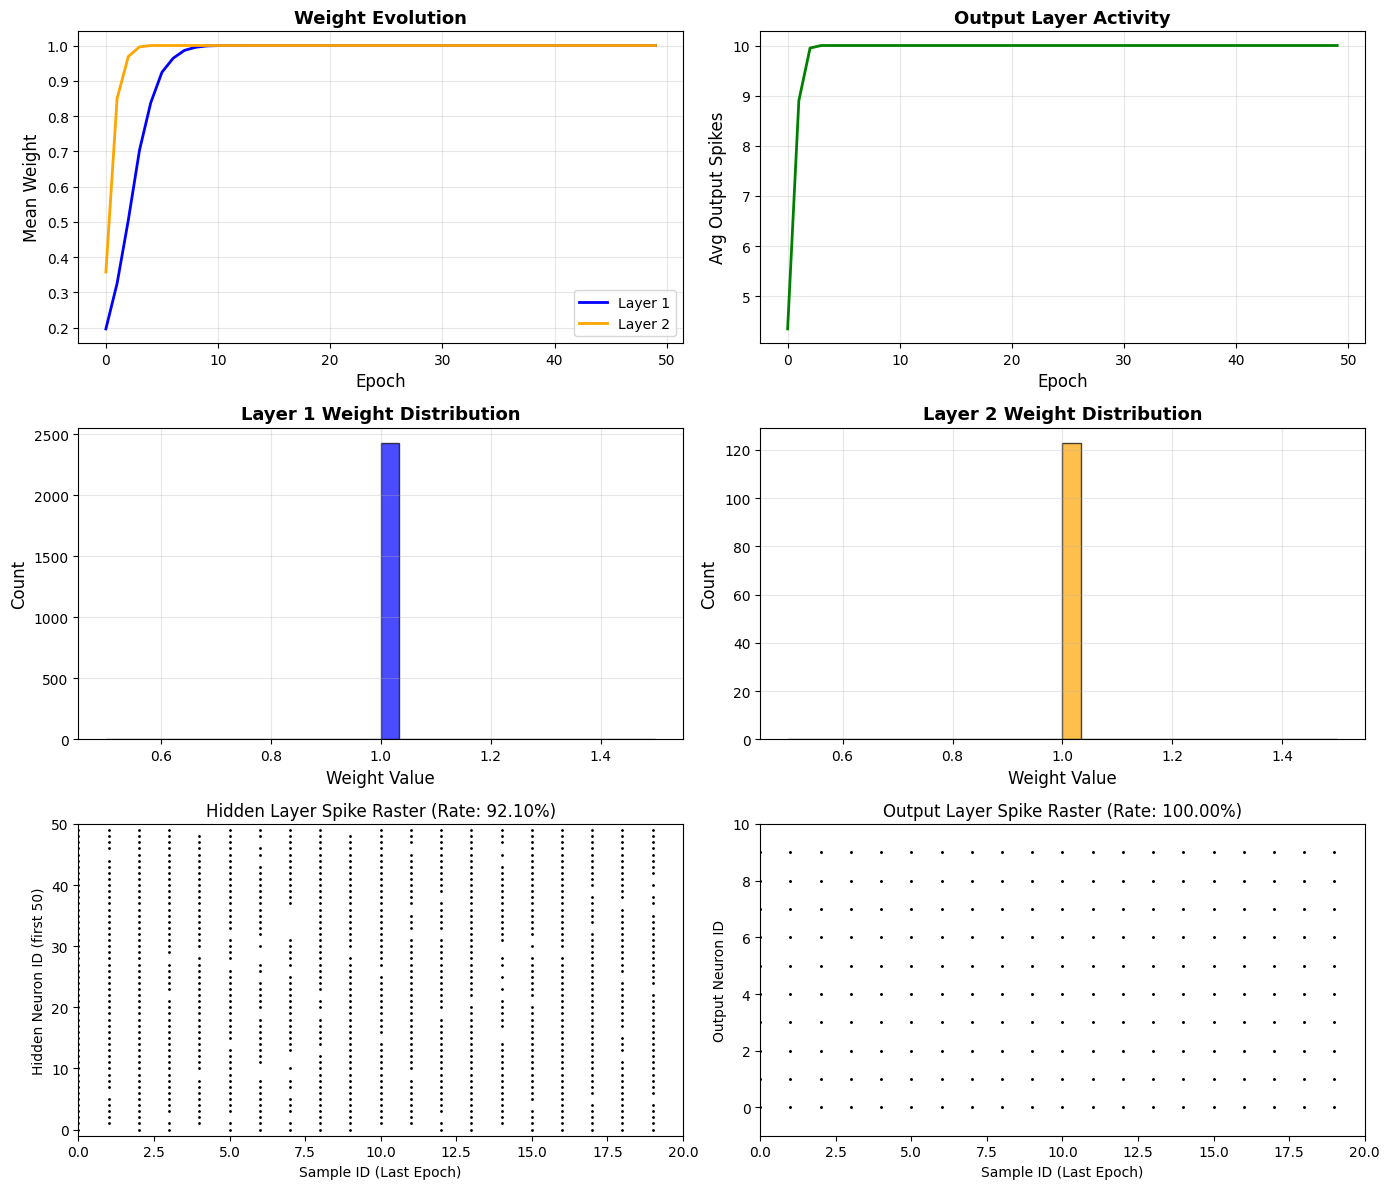

In [14]:
# Visualize Learning Process
fig = plt.figure(figsize=(14, 12))

# Subplot 1: Weight Evolution
ax1 = plt.subplot(3, 2, 1)
ax1.plot(w1_history, label='Layer 1', linewidth=2, color='blue')
ax1.plot(w2_history, label='Layer 2', linewidth=2, color='orange')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Mean Weight', fontsize=12)
ax1.set_title('Weight Evolution', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: Output Activity
ax2 = plt.subplot(3, 2, 2)
ax2.plot(output_activity_history, linewidth=2, color='green')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Avg Output Spikes', fontsize=12)
ax2.set_title('Output Layer Activity', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 子图3: First layerWeight distribution
ax3 = plt.subplot(3, 2, 3)
ax3.hist(adaptive_net.w1.data, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax3.set_xlabel('Weight Value', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
ax3.set_title('Layer 1 Weight Distribution', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 子图4: Second layerWeight distribution
ax4 = plt.subplot(3, 2, 4)
ax4.hist(adaptive_net.w2.data, bins=30, alpha=0.7, color='orange', edgecolor='black')
ax4.set_xlabel('Weight Value', fontsize=12)
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title('Layer 2 Weight Distribution', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Subplot 5: Hidden Layer Spike Raster (using braintools)
ax5 = plt.subplot(3, 2, 5)
ts = np.arange(len(hidden_spike_matrix))
braintools.visualize.raster_plot(
    ts,
    hidden_spike_matrix,
    markersize=4,
    ax=ax5,
    xlim=(0, len(hidden_spike_matrix)),
    ylim=(-1, 50),
    xlabel='Sample ID (Last Epoch)',
    ylabel='Hidden Neuron ID (first 50)',
    title=f'Hidden Layer Spike Raster (Rate: {hidden_spike_matrix.mean():.2%})',
    show=False
)

# Subplot 6: Output Layer Spike Raster (using braintools)
ax6 = plt.subplot(3, 2, 6)
braintools.visualize.raster_plot(
    ts,
    output_spike_matrix,
    markersize=5,
    ax=ax6,
    xlim=(0, len(output_spike_matrix)),
    ylim=(-1, 10),
    xlabel='Sample ID (Last Epoch)',
    ylabel='Output Neuron ID',
    title=f'Output Layer Spike Raster (Rate: {output_spike_matrix.mean():.2%})',
    show=False
)

plt.tight_layout()
plt.show()



## 6. Summary

In this tutorial, we learned:

1. ✅ **Synaptic plasticity principles**: Hebb's Rule和STDP机制
2. ✅ **STDP window**: Time dependency of LTP and LTD
3. ✅ **CSR format STDP**: Using `csr_on_pre` for efficient learning
4. ✅ **COO format STDP**: Using `coo_on_pre` for flexible learning
5. ✅ **Trace mechanism**: Exponentially decaying spike trace
6. ✅ **Adaptive network**: Build complete network with learning capability
7. ✅ **Learning process visualization**: Observe weight evolution and network adaptation

### Key Points
- 🔑 **STDP = Biological learning rule**
- 🔑 **Trace = Record historical spikes**
- 🔑 **BrainEvent provides efficient implementation**
- 🔑 **Supports multiple data structures**